In [46]:
# CS 513: Knowledge Discovery and Data 
# Project: Digital Stress Classifier — RF, ANN, SVM
# Author: Raj Rana
# "I pledge my honor that I have abided by the Stevens Honor System"
# 
# Purpose:
# This notebook extends the digital stress classifier pipeline to three additional models:
#   • Random Forest
#   • Artificial Neural Network (ANN)
#   • Support Vector Machine (SVM)
# using the preprocessed df_modified dataset (data/df_modified.csv).


In [47]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

sns.set(style="whitegrid", context="notebook")


In [48]:
# Load preprocessed digital stress dataset
# Make sure df_modified.csv is saved in the `data/` directory.
df = pd.read_csv("data/df_modified.csv")
df.head()

,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),Gender_Female,Gender_Male,Gender_Other,Social_Media_Platform_Facebook,Social_Media_Platform_Instagram,Social_Media_Platform_LinkedIn,Social_Media_Platform_TikTok,Social_Media_Platform_X (Twitter),Social_Media_Platform_YouTube
0,44,3.1,7.0,6.0,2.0,5.0,10.0,0,1,0,1,0,0,0,0,0
1,30,5.1,7.0,8.0,5.0,3.0,10.0,0,0,1,0,0,1,0,0,0
2,23,7.4,6.0,7.0,1.0,3.0,6.0,0,0,1,0,0,0,0,0,1
3,36,5.7,7.0,8.0,1.0,1.0,8.0,1,0,0,0,0,0,1,0,0
4,34,7.0,4.0,7.0,5.0,1.0,8.0,1,0,0,0,0,0,0,1,0


In [49]:
df["Stress_Binary"] = (df["Stress_Level(1-10)"] >= 6).astype(int)
df = df.drop("Stress_Level(1-10)", axis=1)

# Basic info and class balance check
display(df.info())

print("\nClass balance for Stress_Binary:")
print(df["Stress_Binary"].value_counts(normalize=True).rename("proportion"))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                500 non-null    int64  
 1   Daily_Screen_Time(hrs)             500 non-null    float64
 2   Sleep_Quality(1-10)                500 non-null    float64
 3   Days_Without_Social_Media          500 non-null    float64
 4   Exercise_Frequency(week)           500 non-null    float64
 5   Happiness_Index(1-10)              500 non-null    float64
 6   Gender_Female                      500 non-null    int64  
 7   Gender_Male                        500 non-null    int64  
 8   Gender_Other                       500 non-null    int64  
 9   Social_Media_Platform_Facebook     500 non-null    int64  
 10  Social_Media_Platform_Instagram    500 non-null    int64  
 11  Social_Media_Platform_LinkedIn     500 non-null    int64  

None


Class balance for Stress_Binary:
Stress_Binary
1    0.762
0    0.238
Name: proportion, dtype: float64


In [50]:
# Separate features and target
X = df.drop("Stress_Binary", axis=1)
y = df["Stress_Binary"]

X.head()


,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),Gender_Female,Gender_Male,Gender_Other,Social_Media_Platform_Facebook,Social_Media_Platform_Instagram,Social_Media_Platform_LinkedIn,Social_Media_Platform_TikTok,Social_Media_Platform_X (Twitter),Social_Media_Platform_YouTube
0,44,3.1,7.0,2.0,5.0,10.0,0,1,0,1,0,0,0,0,0
1,30,5.1,7.0,5.0,3.0,10.0,0,0,1,0,0,1,0,0,0
2,23,7.4,6.0,1.0,3.0,6.0,0,0,1,0,0,0,0,0,1
3,36,5.7,7.0,1.0,1.0,8.0,1,0,0,0,0,0,1,0,0
4,34,7.0,4.0,5.0,1.0,8.0,1,0,0,0,0,0,0,1,0


In [51]:
# Standardize features (following the digital-stress-classifier methodology)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[ 1.10665902, -1.40207812,  0.45541937, -0.61069822,  1.78882098,
         1.06652456, -0.91924885,  1.00803226, -0.21958604,  2.27438772,
        -0.41678402, -0.45897032, -0.4843221 , -0.4621604 , -0.42008403],
       [-0.30028125, -0.24810436,  0.45541937,  1.00490554,  0.38692366,
         1.06652456, -0.91924885, -0.99203175,  4.55402354, -0.43967877,
        -0.41678402,  2.17879013, -0.4843221 , -0.4621604 , -0.42008403],
       [-1.00375139,  1.07896547, -0.1989188 , -1.14923281,  0.38692366,
        -1.56038323, -0.91924885, -0.99203175,  4.55402354, -0.43967877,
        -0.41678402, -0.45897032, -0.4843221 , -0.4621604 ,  2.38047614],
       [ 0.30269315,  0.09808777,  0.45541937, -1.14923281, -1.01497366,
        -0.24692933,  1.08784471, -0.99203175, -0.21958604, -0.43967877,
        -0.41678402, -0.45897032,  2.0647416 , -0.4621604 , -0.42008403],
       [ 0.10170168,  0.84817072, -1.50759514,  1.00490554, -1.01497366,
        -0.24692933,  1.08784471, -0.99203175, 

In [52]:
# Train–test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((350, 15), (150, 15))

In [53]:
def evaluate_model(name, y_true, y_pred):
    """Prints accuracy, confusion matrix, and classification report."""
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f} ({acc:.2%})\n")
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

## Random Forest Classifier

Random Forest training time: 0.67 seconds
Random Forest Accuracy: 0.8867 (88.67%)

Confusion Matrix:
[[ 25  11]
 [  6 108]]


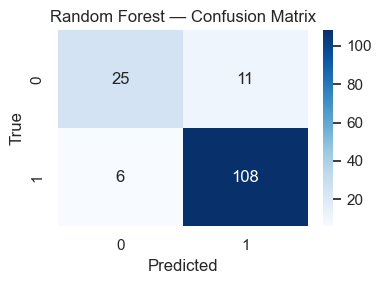


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75        36
           1       0.91      0.95      0.93       114

    accuracy                           0.89       150
   macro avg       0.86      0.82      0.84       150
weighted avg       0.88      0.89      0.88       150



In [54]:
# Train Random Forest model with timing
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_train_time = time.time() - start_time
print(f"Random Forest training time: {rf_train_time:.2f} seconds")

rf_pred = rf_model.predict(X_test)

evaluate_model("Random Forest", y_test, rf_pred)


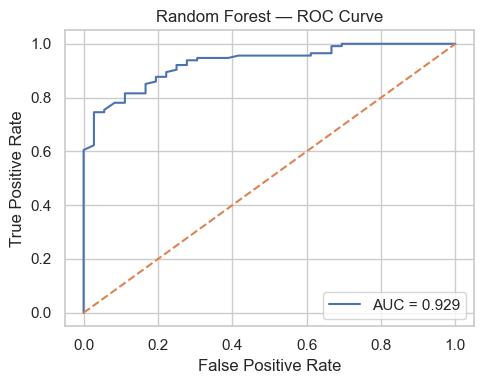

Random Forest AUC: 0.9288


In [55]:
# Random Forest ROC curve and AUC
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # probability of class 1

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 4))
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {roc_auc_rf:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest — ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Random Forest AUC: {roc_auc_rf:.4f}")

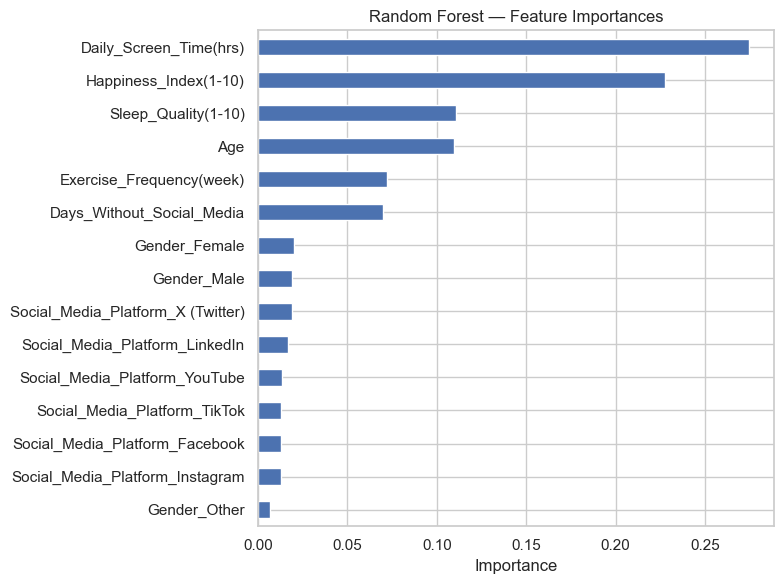

Daily_Screen_Time(hrs)               0.274831
Happiness_Index(1-10)                0.227780
Sleep_Quality(1-10)                  0.110784
Age                                  0.109651
Exercise_Frequency(week)             0.072050
Days_Without_Social_Media            0.069845
Gender_Female                        0.020404
Gender_Male                          0.019148
Social_Media_Platform_X (Twitter)    0.018932
Social_Media_Platform_LinkedIn       0.016985
Social_Media_Platform_YouTube        0.013409
Social_Media_Platform_TikTok         0.013138
Social_Media_Platform_Facebook       0.013134
Social_Media_Platform_Instagram      0.013042
Gender_Other                         0.006867
dtype: float64

In [56]:
# Feature importances for Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
rf_importances.plot(kind="barh")
plt.title("Random Forest — Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

rf_importances.sort_values(ascending=False)

## Artificial Neural Network (MLPClassifier)

ANN training time: 2.05 seconds
ANN (MLPClassifier) Accuracy: 0.8067 (80.67%)

Confusion Matrix:
[[ 19  17]
 [ 12 102]]


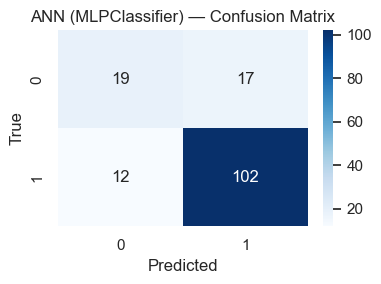


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57        36
           1       0.86      0.89      0.88       114

    accuracy                           0.81       150
   macro avg       0.74      0.71      0.72       150
weighted avg       0.80      0.81      0.80       150



In [57]:
# Train ANN (MLPClassifier) with timing
start_time = time.time()

ann_model = MLPClassifier(
    hidden_layer_sizes=(16, 8),  # same as you used
    max_iter=2000,
    random_state=42
)

ann_model.fit(X_train, y_train)

ann_train_time = time.time() - start_time
print(f"ANN training time: {ann_train_time:.2f} seconds")

ann_pred = ann_model.predict(X_test)

evaluate_model("ANN (MLPClassifier)", y_test, ann_pred)

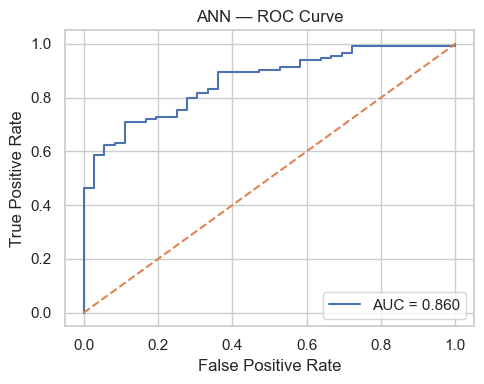

ANN AUC: 0.8604


In [58]:
# ANN ROC curve and AUC
ann_probs = ann_model.predict_proba(X_test)[:, 1]  # probability of class 1

fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_probs)
roc_auc_ann = auc(fpr_ann, tpr_ann)

plt.figure(figsize=(5, 4))
plt.plot(fpr_ann, tpr_ann, label=f"AUC = {roc_auc_ann:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN — ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"ANN AUC: {roc_auc_ann:.4f}")


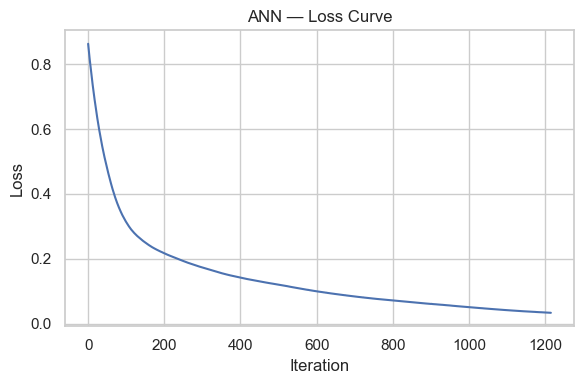

In [59]:
# Loss curve for ANN
plt.figure(figsize=(6, 4))
plt.plot(ann_model.loss_curve_)
plt.title("ANN — Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

## Support Vector Machine (SVM)

SVM training time: 0.01 seconds
SVM (RBF kernel) Accuracy: 0.8533 (85.33%)

Confusion Matrix:
[[ 20  16]
 [  6 108]]


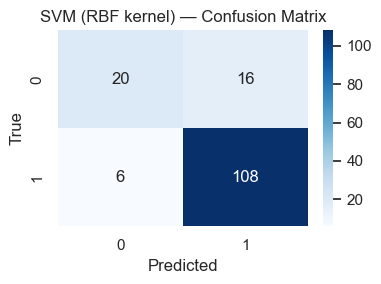


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.56      0.65        36
           1       0.87      0.95      0.91       114

    accuracy                           0.85       150
   macro avg       0.82      0.75      0.78       150
weighted avg       0.85      0.85      0.84       150



In [60]:
# Train Support Vector Machine with RBF kernel (with timing)
start_time = time.time()

svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42
)

svm_model.fit(X_train, y_train)

svm_train_time = time.time() - start_time
print(f"SVM training time: {svm_train_time:.2f} seconds")

svm_pred = svm_model.predict(X_test)

evaluate_model("SVM (RBF kernel)", y_test, svm_pred)


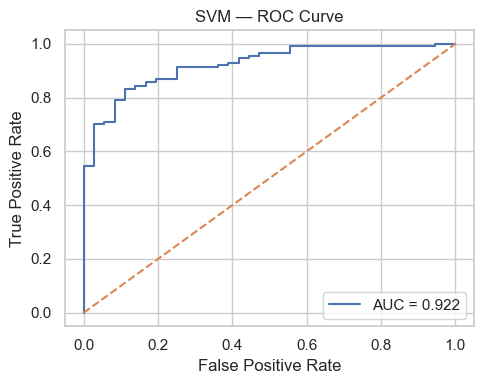

SVM AUC: 0.9220


In [61]:
# SVM ROC curve and AUC using decision_function scores
svm_scores = svm_model.decision_function(X_test)  # distance from the hyperplane

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(5, 4))
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {roc_auc_svm:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM — ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"SVM AUC: {roc_auc_svm:.4f}")


In [62]:
# Summary comparison across models
rf_acc = accuracy_score(y_test, rf_pred)
ann_acc = accuracy_score(y_test, ann_pred)
svm_acc = accuracy_score(y_test, svm_pred)

summary_df = pd.DataFrame({
    "Model": ["Random Forest", "ANN", "SVM"],
    "Accuracy": [rf_acc, ann_acc, svm_acc],
    "AUC": [roc_auc_rf, roc_auc_ann, roc_auc_svm],
    "Train time (sec)": [rf_train_time, ann_train_time, svm_train_time]
})

summary_df


,Model,Accuracy,AUC,Train time (sec)
0,Random Forest,0.886667,0.928850,0.666008
1,ANN,0.806667,0.860380,2.045975
2,SVM,0.853333,0.922027,0.010006
